# Sheet 9 (Bhavesh Rajpoot, Simran Joahrle, Sachin Gupta)

In [36]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='monospace', size=14, serif='courier')
plt.rc('mathtext', fontset='stix')

import torch
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision 

from tqdm.notebook import tqdm

## 1 Jet-Tagging with PyTorch
(a)

In [46]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)

elif torch.backends.cuda:
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("GPU device not found.")

tensor([1.], device='cuda:0')


In [ ]:
# load the dijet data
features = np.load('data/dijet_features_normalized.npy').T
labels = np.load('data/dijet_labels.npy')

# shuffle the data
order = np.arange(len(labels))
np.random.seed(0)
np.random.shuffle(order)
features = features[order]
labels = labels[order]

n_features = features.shape[1]
print(n_features)
print(f'{features.shape=}, {labels.shape=}')

#converting the np arrays to tensor
features_tensor = torch.from_numpy(features).to(torch.float32)
labels_tensor = torch.from_numpy(labels).to(torch.float32)

# TODO: create the datsets
dijet_dataset = TensorDataset(features_tensor,labels_tensor)

# TODO: create train, val and test splits
N=200 #size of split
train,val,test = random_split(dijet_dataset,[features.shape[0]-2*N,N,N])

print(f'{len(train)=}')
print(f'{len(val)=}')
print(f'{len(test)=}')

116
features.shape=(2233, 116), labels.shape=(2233,)
len(train)=1833
len(val)=200
len(test)=200


(b)

In [ ]:
# TODO: Instantiate an MLP as specified
mlp_model = torchvision.ops.MLP(in_channels = n_features, 
            hidden_channels = (128,128,128,128,3),
            )

(c)

In [ ]:
# TODO: create the optimizer
optimizer = Adam(mlp_model.parameters(), lr=1e-4)

# TODO: create the criterion
criterion = torch.nn.CrossEntropyLoss()

(d)

In [ ]:
# TODO: create the data loaders, use a batch size of 16
batch_size = 16

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# TODO: Implement the training loop, validating after every epoch and keeping track of losses and accuracies

tot_train_loss,tot_val_loss =[],[]
tot_train_accuracy,tot_val_accuracy = [],[]

min_val_loss = np.Inf

for epoch in tqdm(range(50),total=len(range(50))):
    ind_train_loss,ind_val_loss = 0.0,0.0
    train_accuracy,val_accuracy = 0.0,0.0
    train_total,val_total  = 0.0,0.0

    for (x, y) in train_loader:
        #TODO: train step
        inputs, labels = x,y        # get the inputs; data is a list of [inputs, labels]
        optimizer.zero_grad()       # zero the parameter gradients

        outputs = mlp_model(inputs) # predicting output from the model 

        loss = criterion(outputs.to(torch.float64), labels.to(torch.long)) # calculating loss for the predicted output  
        loss.backward()             # backpropagating the loss 
        optimizer.step()            # adjusting the parameters based on the calculated gradients 

        ind_train_loss += loss.item()       # track the loss value 
    
        train_total += labels.size(0)       # tracking the total no. of training predictions
        _, predicted = torch.max(outputs, 1)        # choosing the label with the highest value as our prediction 
        train_accuracy += (predicted == labels).sum().item()        # estimating the no. of correct predictions

    tot_train_loss.append(ind_train_loss/len(train_loader)) # calculating and storing the training loss value for individual epoch run

    # accuracy = the number of correct predictions in the validation batch / the total number of predictions done.  
    tot_train_accuracy.append((100 * train_accuracy / train_total))  # storing the training accuracy for individual epoch run

            
    # TODO: validate 
    with torch.no_grad(): 
            mlp_model.eval() 
            for data in val_loader: 
               inputs, labels = data 
               outputs = mlp_model(inputs) 
               val_loss = criterion(outputs.to(torch.float64), labels.to(torch.long))
             
               ind_val_loss += val_loss.item() 

               val_total += labels.size(0) 
               _, predicted = torch.max(outputs, 1) 
               val_accuracy += (predicted == labels).sum().item() 
    
    val_loss_value = ind_val_loss/len(val_loader) # calculating the validation loss value for individual epoch run
    tot_val_loss.append(val_loss_value)   # storing the validation loss 

    tot_val_accuracy.append((100 * val_accuracy / val_total)) # storing the validation accuracy for individual epoch run

    if val_loss_value < min_val_loss  :
        print(f'Epoch: {epoch}; Validation loss decreased: ({min_val_loss:.6f} --> {val_loss_value:.6f}). Model Accuracy: Training-{(100 * train_accuracy / train_total):.2f}%; Validation-{(100 * val_accuracy / val_total):.2f}%; . Saving model ...')
        torch.save({
                'epoch': epoch,
                'model_state_dict': mlp_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')
        min_val_loss = val_loss_value 

print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0; Validation loss decreased: (inf --> 0.933843). Model Accuracy: Training-44.63%; Validation-60.00%; . Saving model ...
Epoch: 1; Validation loss decreased: (0.933843 --> 0.555603). Model Accuracy: Training-68.74%; Validation-72.50%; . Saving model ...
Epoch: 2; Validation loss decreased: (0.555603 --> 0.502472). Model Accuracy: Training-72.56%; Validation-73.00%; . Saving model ...
Epoch: 3; Validation loss decreased: (0.502472 --> 0.458140). Model Accuracy: Training-75.67%; Validation-77.00%; . Saving model ...
Epoch: 4; Validation loss decreased: (0.458140 --> 0.443549). Model Accuracy: Training-77.36%; Validation-79.00%; . Saving model ...
Epoch: 5; Validation loss decreased: (0.443549 --> 0.434664). Model Accuracy: Training-78.56%; Validation-76.50%; . Saving model ...
Epoch: 6; Validation loss decreased: (0.434664 --> 0.409412). Model Accuracy: Training-80.63%; Validation-79.00%; . Saving model ...
Epoch: 11; Validation loss decreased: (0.409412 --> 0.408792). Model Accur

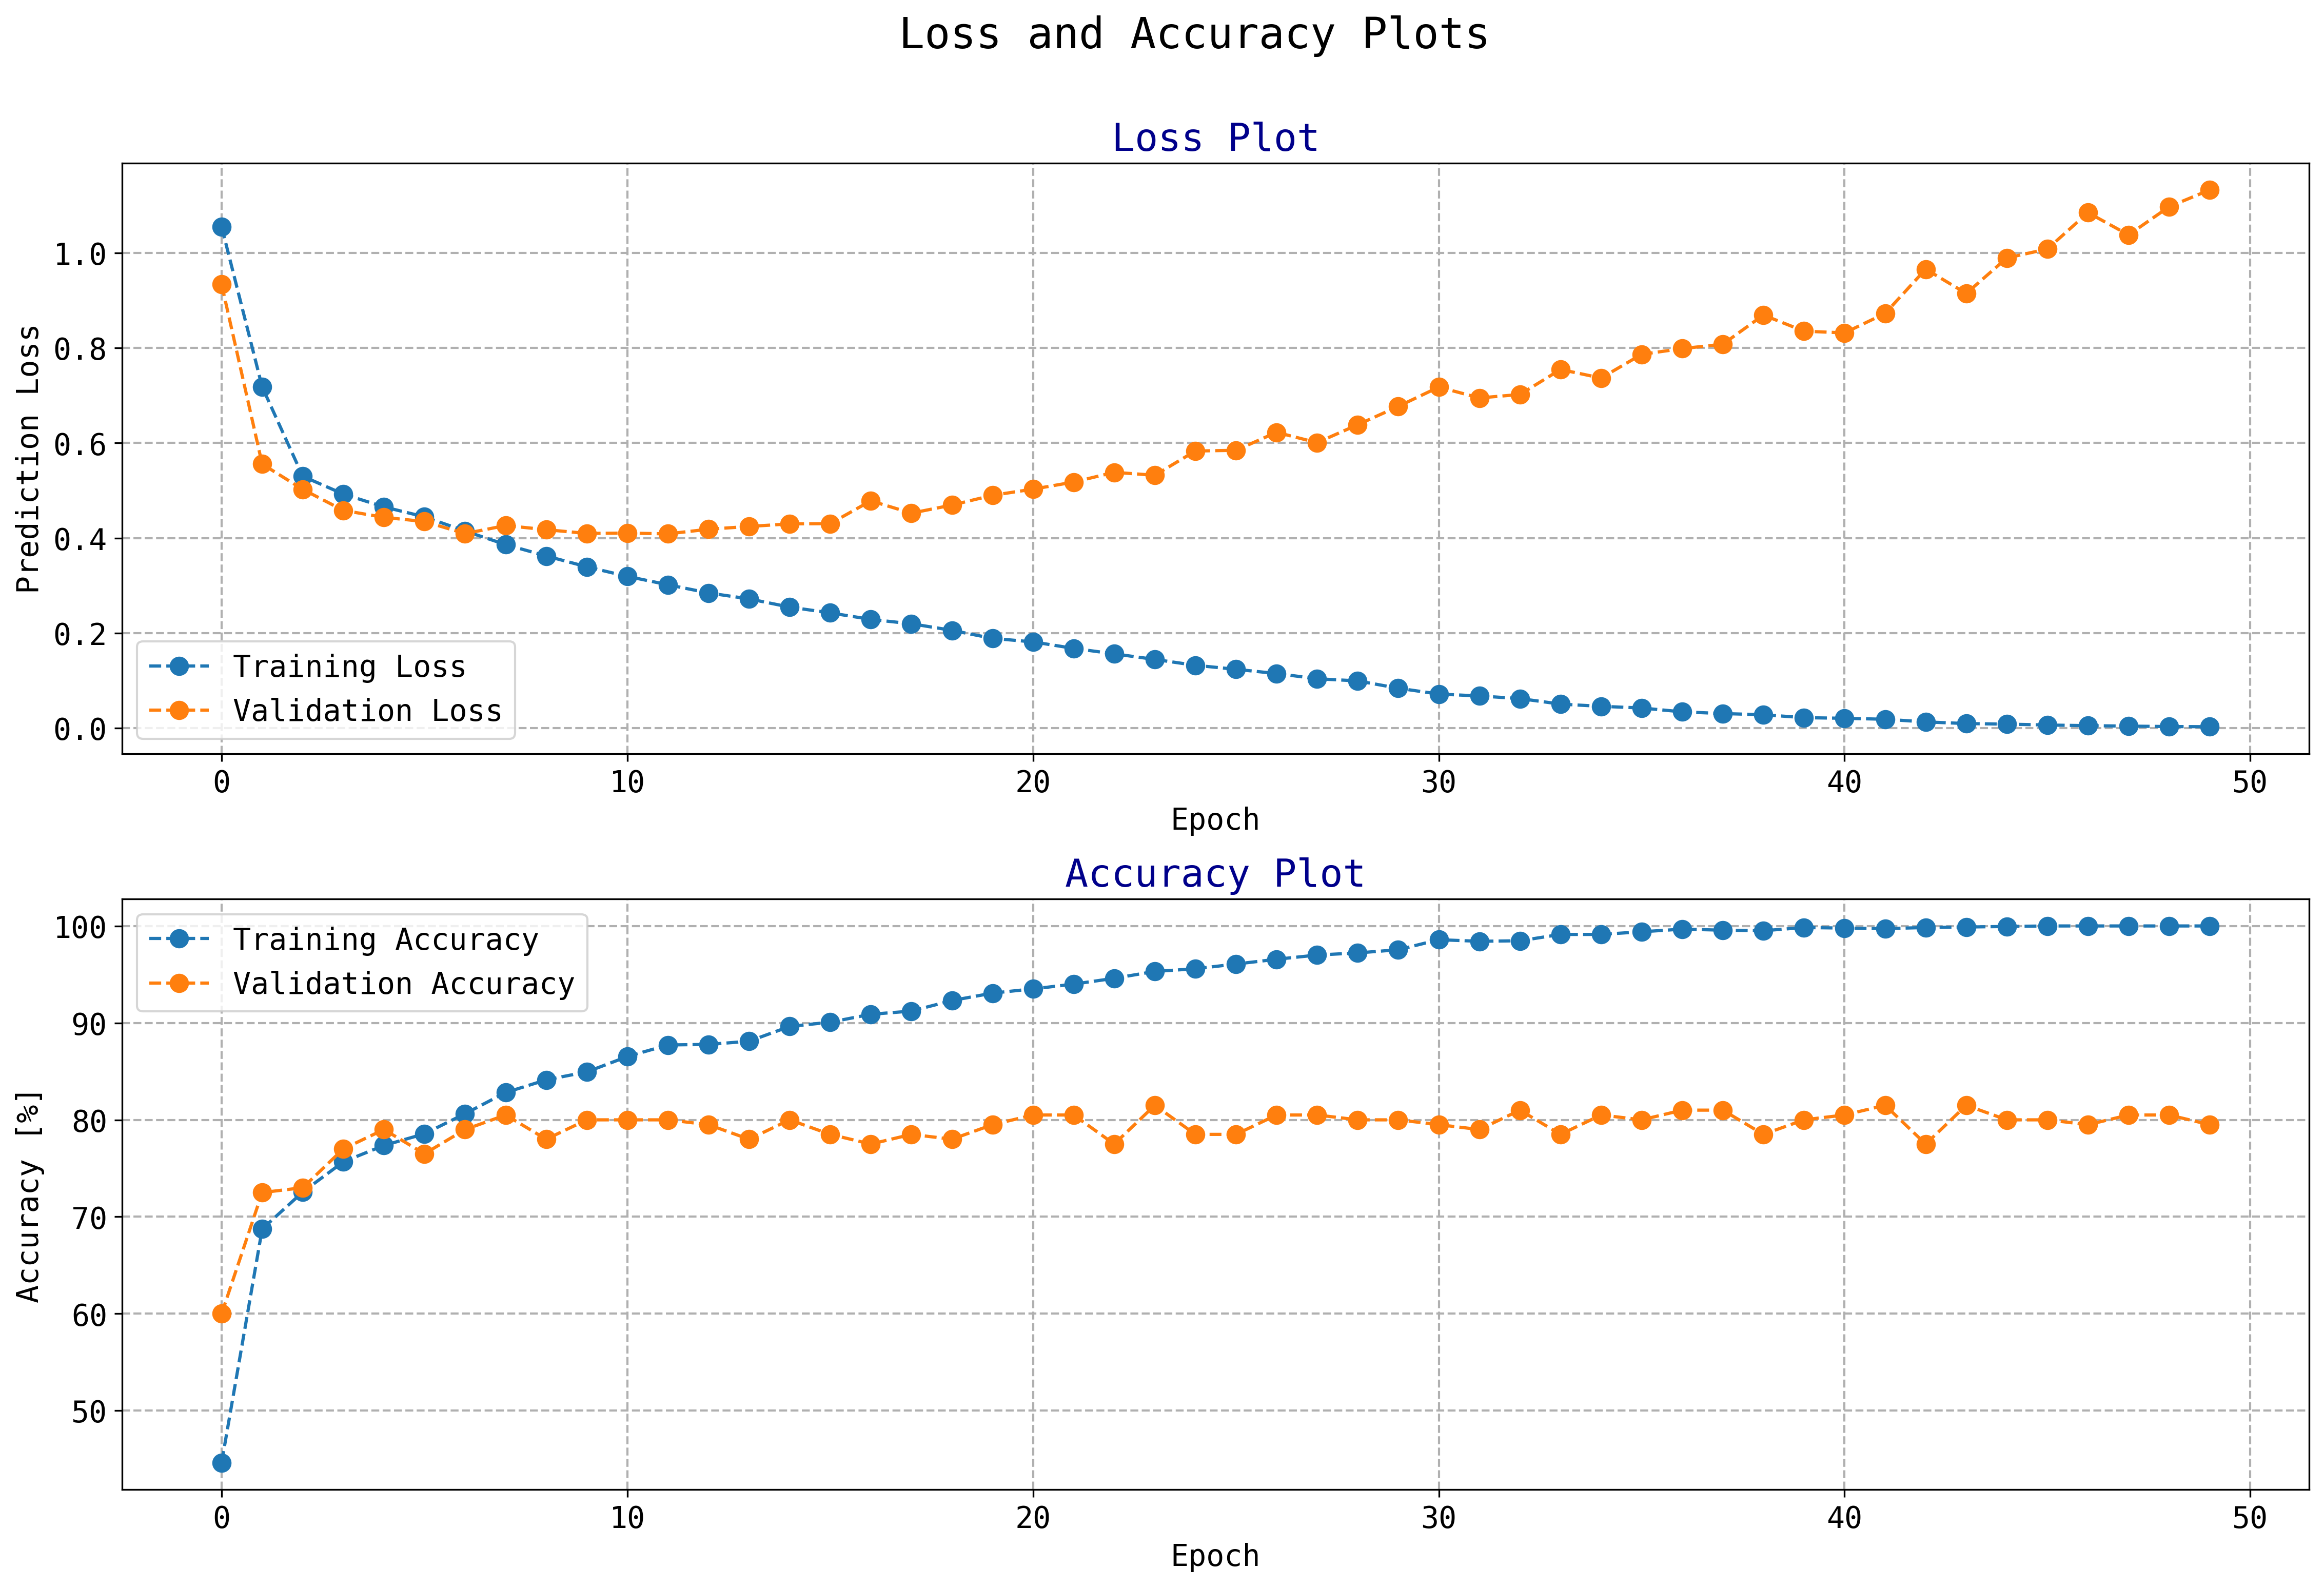

In [ ]:
# TODO: Plot the losses and accuracies.
fig,ax = plt.subplots(2,1,figsize=(16,11),dpi=300)
plt.suptitle('Loss and Accuracy Plots', fontsize=20, y=0.95)
fig.tight_layout(pad=3)

x = range(30)

# loss plot
ax[0].plot(tot_train_loss,'--o',markersize=8,label='Training Loss')
ax[0].plot(tot_val_loss,'--o',markersize=8,label='Validation Loss')
ax[0].grid(linestyle='--', linewidth=1)
ax[0].set_title(f'Loss Plot',fontdict={'fontsize': 18,'color': 'darkblue'})
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Prediction Loss')
ax[0].legend()

# accuracy plot
ax[1].plot(tot_train_accuracy,'--o',markersize=8,label='Training Accuracy')
ax[1].plot(tot_val_accuracy,'--o',markersize=8,label='Validation Accuracy')
ax[1].grid(linestyle='--', linewidth=1)
ax[1].set_title(f'Accuracy Plot',fontdict={'fontsize': 18,'color': 'darkblue'})
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy [%]')
ax[1].legend();

### Inference:

In the Loss plot:
- With each increasing epoch, we can observe:
  - the `training loss` *decreased* &
  - the `validation loss` first *decreased*, and then started to *increse* from 12th epoch and kept increasing till the end.

- This was an expected behaviour because
  - we know that as the model trains for long enough, then the `training loss` becomes *very small* which means the model `overfitted`
  - and during `overfitting`, we know the validation loss *increases* because the model becomes less certain regarding it's predictions. And we can see this in our Loss plot. 
  - Therefore, we had saved our model when the `validation loss` was *least*.

In the Accuracy plot:
- The `training accuracy` keeps *increasing* till the end which is expected because `training loss` *decreases*, as it keeps `overfitting` the training data.
- Intuitively, looking at the training curves, it's very easy to say `accuracy` is inversely proportional to `loss`, but that is wrong, as *accuracy measures the correctness of the model* whereas *loss tracks the inverse-confidence of model predictions*. 
  
- Therefore, we can see that the `validation accuracy` wobbles around 80% accuracy after the 6th/7th epoch instead of decreasing. This is because our model has stopped learning. 


(e)

In [ ]:
# TODO: load the best model and evaluate it on the test set
model = torchvision.ops.MLP(in_channels = n_features,hidden_channels = (128,128,128,128,3))

model_path = 'best_model.pth'
best_model = torch.load(model_path)

model.load_state_dict(best_model['model_state_dict']) 

with torch.no_grad(): 
    model.eval()
    test_accuracy = 0.0 
    test_total = 0.0
    for data in test_loader: 
        inputs, labels = data 
        outputs = mlp_model(inputs) 

        _, predicted = torch.max(outputs, 1) 
        test_total += labels.size(0) 
        test_accuracy += (predicted == labels).sum().item() 

    print(f'Accuracy of the model based on the Test Set: {(100 * test_accuracy / test_total)}%')   

Accuracy of the model based on the Test Set: 76.0%


(f)

In [ ]:
# TODO: experiment with some hyperparameters and discuss your results

## Task 2: CNNs for Galaxy Classification

Read through and run the cells below to get started

In [ ]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

In [7]:
# download the data 
# it's ~200MB, might take some time depending on your internet speed

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
    "Galaxy10.h5"
)

In [8]:
import h5py

label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)
print(f'{n_classes=}')

# To get the images and labels from file
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
with h5py.File('Galaxy10_compressed.h5', 'w') as f:
    f.create_dataset('images', data=images.astype(np.float16), compression='gzip')
    f.create_dataset('ans', data=labels.astype(np.int32), compression='gzip')
    
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape= }; {labels.shape= }')

print(f'\nNumber of samples per class:')
for label, count in zip(*np.unique(labels, return_counts=True)):
    print(f'{label_names[label]:40s}: {count}')

n_classes=10
images.shape= torch.Size([21785, 3, 69, 69]); labels.shape= torch.Size([21785])

Number of samples per class:
Disk, Face-on, No Spiral                : 3461
Smooth, Completely round                : 6997
Smooth, in-between round                : 6292
Smooth, Cigar shaped                    : 349
Disk, Edge-on, Rounded Bulge            : 1534
Disk, Edge-on, Boxy Bulge               : 17
Disk, Edge-on, No Bulge                 : 589
Disk, Face-on, Tight Spiral             : 1121
Disk, Face-on, Medium Spiral            : 906
Disk, Face-on, Loose Spiral             : 519


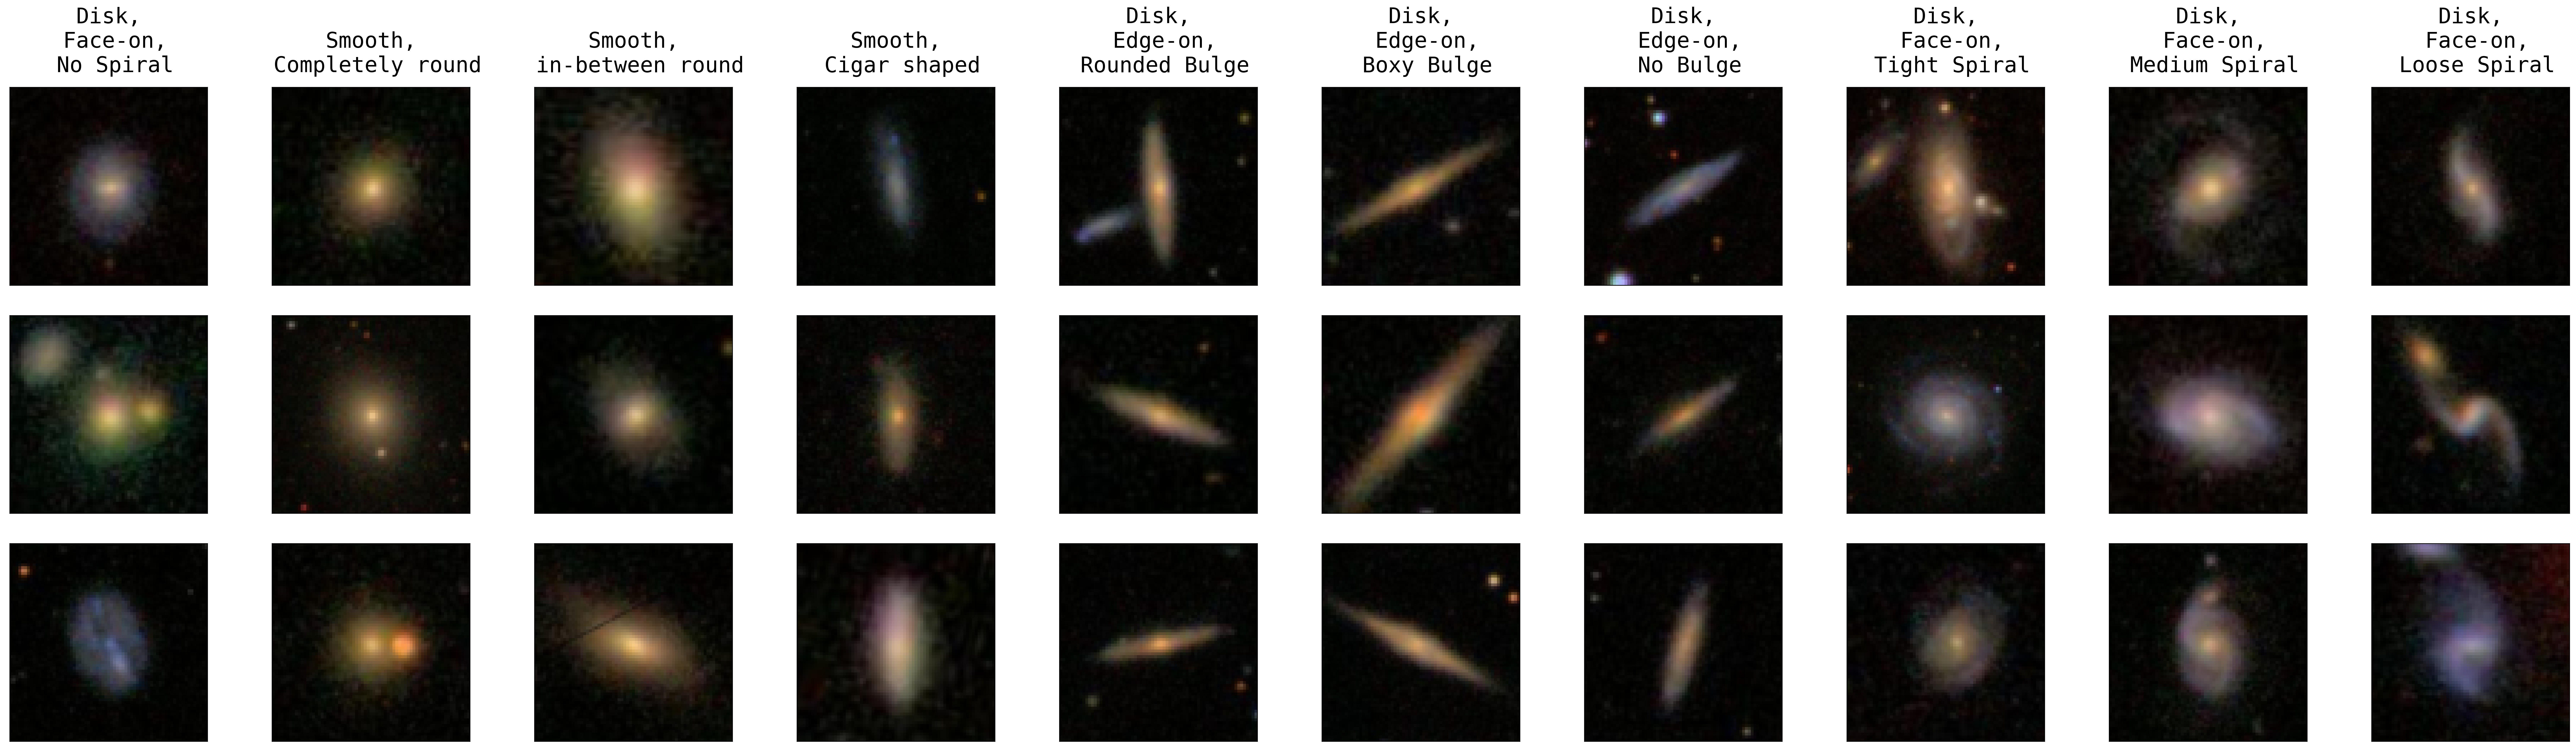

In [9]:
# plot some samples of each class
itemindex = torch.where(labels == 3)
itemindex[:3]

samples_per_class = 3
fig, axss = plt.subplots(samples_per_class, n_classes, figsize=(n_classes * 4, samples_per_class * 4),dpi=300)
for label, (label_name, axs) in enumerate(zip(label_names, axss.T)):
    idx = torch.where(labels==label)[0][:samples_per_class] # take samples_per_class first occurences
    for i, (ind, ax) in enumerate(zip(idx, axs)):
        ax.imshow(images[ind].long().moveaxis(0, -1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title(label_name.replace(',',',\n'),fontdict={'fontsize':24},y=1.05)
fig.tight_layout()
plt.show()

In [10]:
from torchvision.transforms import Normalize

# Compute the mean and standard deviation per channel over the dataset
# stds = images.moveaxis(1, 0).reshape(3, -1).std(axis=1)
# means = images.moveaxis(1, 0).reshape(3, -1).mean(axis=1)

# Use precomputed means and stds
stds, means = torch.tensor([37.5412, 31.3756, 26.3283]), torch.tensor([27.7014, 23.8241, 18.1425])

# TODO: Normalize the images
normalize = Normalize(means, stds)
images_normalized = normalize(images)

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

n_samples = len(labels)

# split the data in training and validation sets, stratifying by the labels
train_idx, val_idx = train_test_split(np.arange(n_samples), test_size=0.1, stratify=labels)

# create pytorch datasets for training and validation
train_dataset = TensorDataset(images_normalized[train_idx].float(), labels[train_idx].long())
val_dataset = TensorDataset(images_normalized[val_idx].float(), labels[val_idx].long())

(a)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

#TODO: implement a small CNN as specified on the sheet    

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # the first convolutional layer, followed by ReLU activation, 
        # and then Max Pooling
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=1),                  # creates a 8x67x67 conv layer
            # nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(3,padding=1)                                   # creates a 8x23x23 max pooling layer
        )

        # second convolutional layer has a similar sequence
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=1),                 # creates a 16x21x21 conv layer
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(3,padding=1)                                   # creates a 16x7x7 max pooling layer
        )

        # the final fully connected layer with flattening layer and MLP
        self.fc = nn.Sequential(
            nn.Flatten(),         
            nn.Linear(16*7*7, 64), 
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,n_classes),
        )

    # this is the forward pass
    def forward(self, x):
        out = self.conv1(x)     #1st conv block
        out = self.conv2(out)   #2nd conv block
        out = self.fc(out)      #Fully connected layers with flattening layer and MLP
        return out

In [13]:
conv = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=5, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3,padding=1),
    nn.Conv2d(8, 16, kernel_size=5, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3,padding=1),
    nn.Flatten(),
    nn.Linear(16*7*7, 64), 
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,n_classes)
)

inputs = torch.rand(16,3,69,69)
out = conv(inputs)
print(out.shape)

# from torchsummary import summary 
# _ = summary(Net(),input_size=inputs.shape)

torch.Size([16, 10])


(b)

In [44]:
# TODO: create DataLoaders for train and val, use a batch size of 16
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True,pin_memory_device='cuda')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,pin_memory=True,pin_memory_device='cuda')


# TODO: instantiate the model, optimizer and criterion
cnn_model = CNN().to(device)

optimizer = Adam(cnn_model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# TODO: implement the training loop, validating after every epoch, and make the requested plots
tot_train_loss,tot_val_loss =[],[]
tot_train_accuracy,tot_val_accuracy = [],[]

min_val_loss = np.Inf

for epoch in tqdm(range(60),total=len(range(60))):
    ind_train_loss,ind_val_loss = 0.0,0.0
    train_accuracy,val_accuracy = 0.0,0.0
    train_total,val_total  = 0.0,0.0

    for (x, y) in train_loader:
        #TODO: train step
        inputs, labels = x,y      

        inputs = inputs.to(device)  
        labels = labels.to(device)
         
        optimizer.zero_grad()   

        outputs = cnn_model(inputs) 

        loss = criterion(outputs, labels)  
        loss.backward()             
        optimizer.step()           

        ind_train_loss += loss.item()  
    
        train_total += labels.size(0)    
        _, predicted = torch.max(outputs, 1)       
        train_accuracy += (predicted == labels).sum().item()  

    tot_train_loss.append(ind_train_loss/len(train_loader))  
    tot_train_accuracy.append((100 * train_accuracy / train_total))  

    # TODO: validate 
    with torch.no_grad(): 
            cnn_model.eval() 
            for data in val_loader: 
               inputs, labels = data
               inputs = inputs.to(device)
               labels = labels.to(device)

               outputs = cnn_model(inputs)
               val_loss = criterion(outputs, labels)
             
               ind_val_loss += val_loss.item() 

               val_total += labels.size(0) 
               _, predicted = torch.max(outputs, 1) 
               val_accuracy += (predicted == labels).sum().item() 
    
    val_loss_value = ind_val_loss/len(val_loader) 
    tot_val_loss.append(val_loss_value)   

    tot_val_accuracy.append((100 * val_accuracy / val_total)) 

    if val_loss_value < min_val_loss  :
        print(f'Epoch: {epoch}; Validation loss decreased: ({min_val_loss:.6f} --> {val_loss_value:.6f}). Model Accuracy: Training-{(100 * train_accuracy / train_total):.2f}%; Validation-{(100 * val_accuracy / val_total):.2f}%; . Saving model ...')
        torch.save({
                'epoch': epoch,
                'model_state_dict': cnn_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model_cnn.pth')
        min_val_loss = val_loss_value 

print('Finished Training')

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0; Validation loss decreased: (inf --> 1.393565). Model Accuracy: Training-38.02%; Validation-47.59%; . Saving model ...
Epoch: 1; Validation loss decreased: (1.393565 --> 1.137848). Model Accuracy: Training-54.09%; Validation-58.05%; . Saving model ...
Epoch: 2; Validation loss decreased: (1.137848 --> 1.024377). Model Accuracy: Training-59.77%; Validation-63.47%; . Saving model ...
Epoch: 3; Validation loss decreased: (1.024377 --> 0.990683). Model Accuracy: Training-62.49%; Validation-63.01%; . Saving model ...
Epoch: 4; Validation loss decreased: (0.990683 --> 0.943382). Model Accuracy: Training-63.49%; Validation-64.48%; . Saving model ...
Epoch: 5; Validation loss decreased: (0.943382 --> 0.917342). Model Accuracy: Training-65.10%; Validation-65.95%; . Saving model ...
Epoch: 7; Validation loss decreased: (0.917342 --> 0.884321). Model Accuracy: Training-66.74%; Validation-66.87%; . Saving model ...
Epoch: 9; Validation loss decreased: (0.884321 --> 0.852466). Model Accura

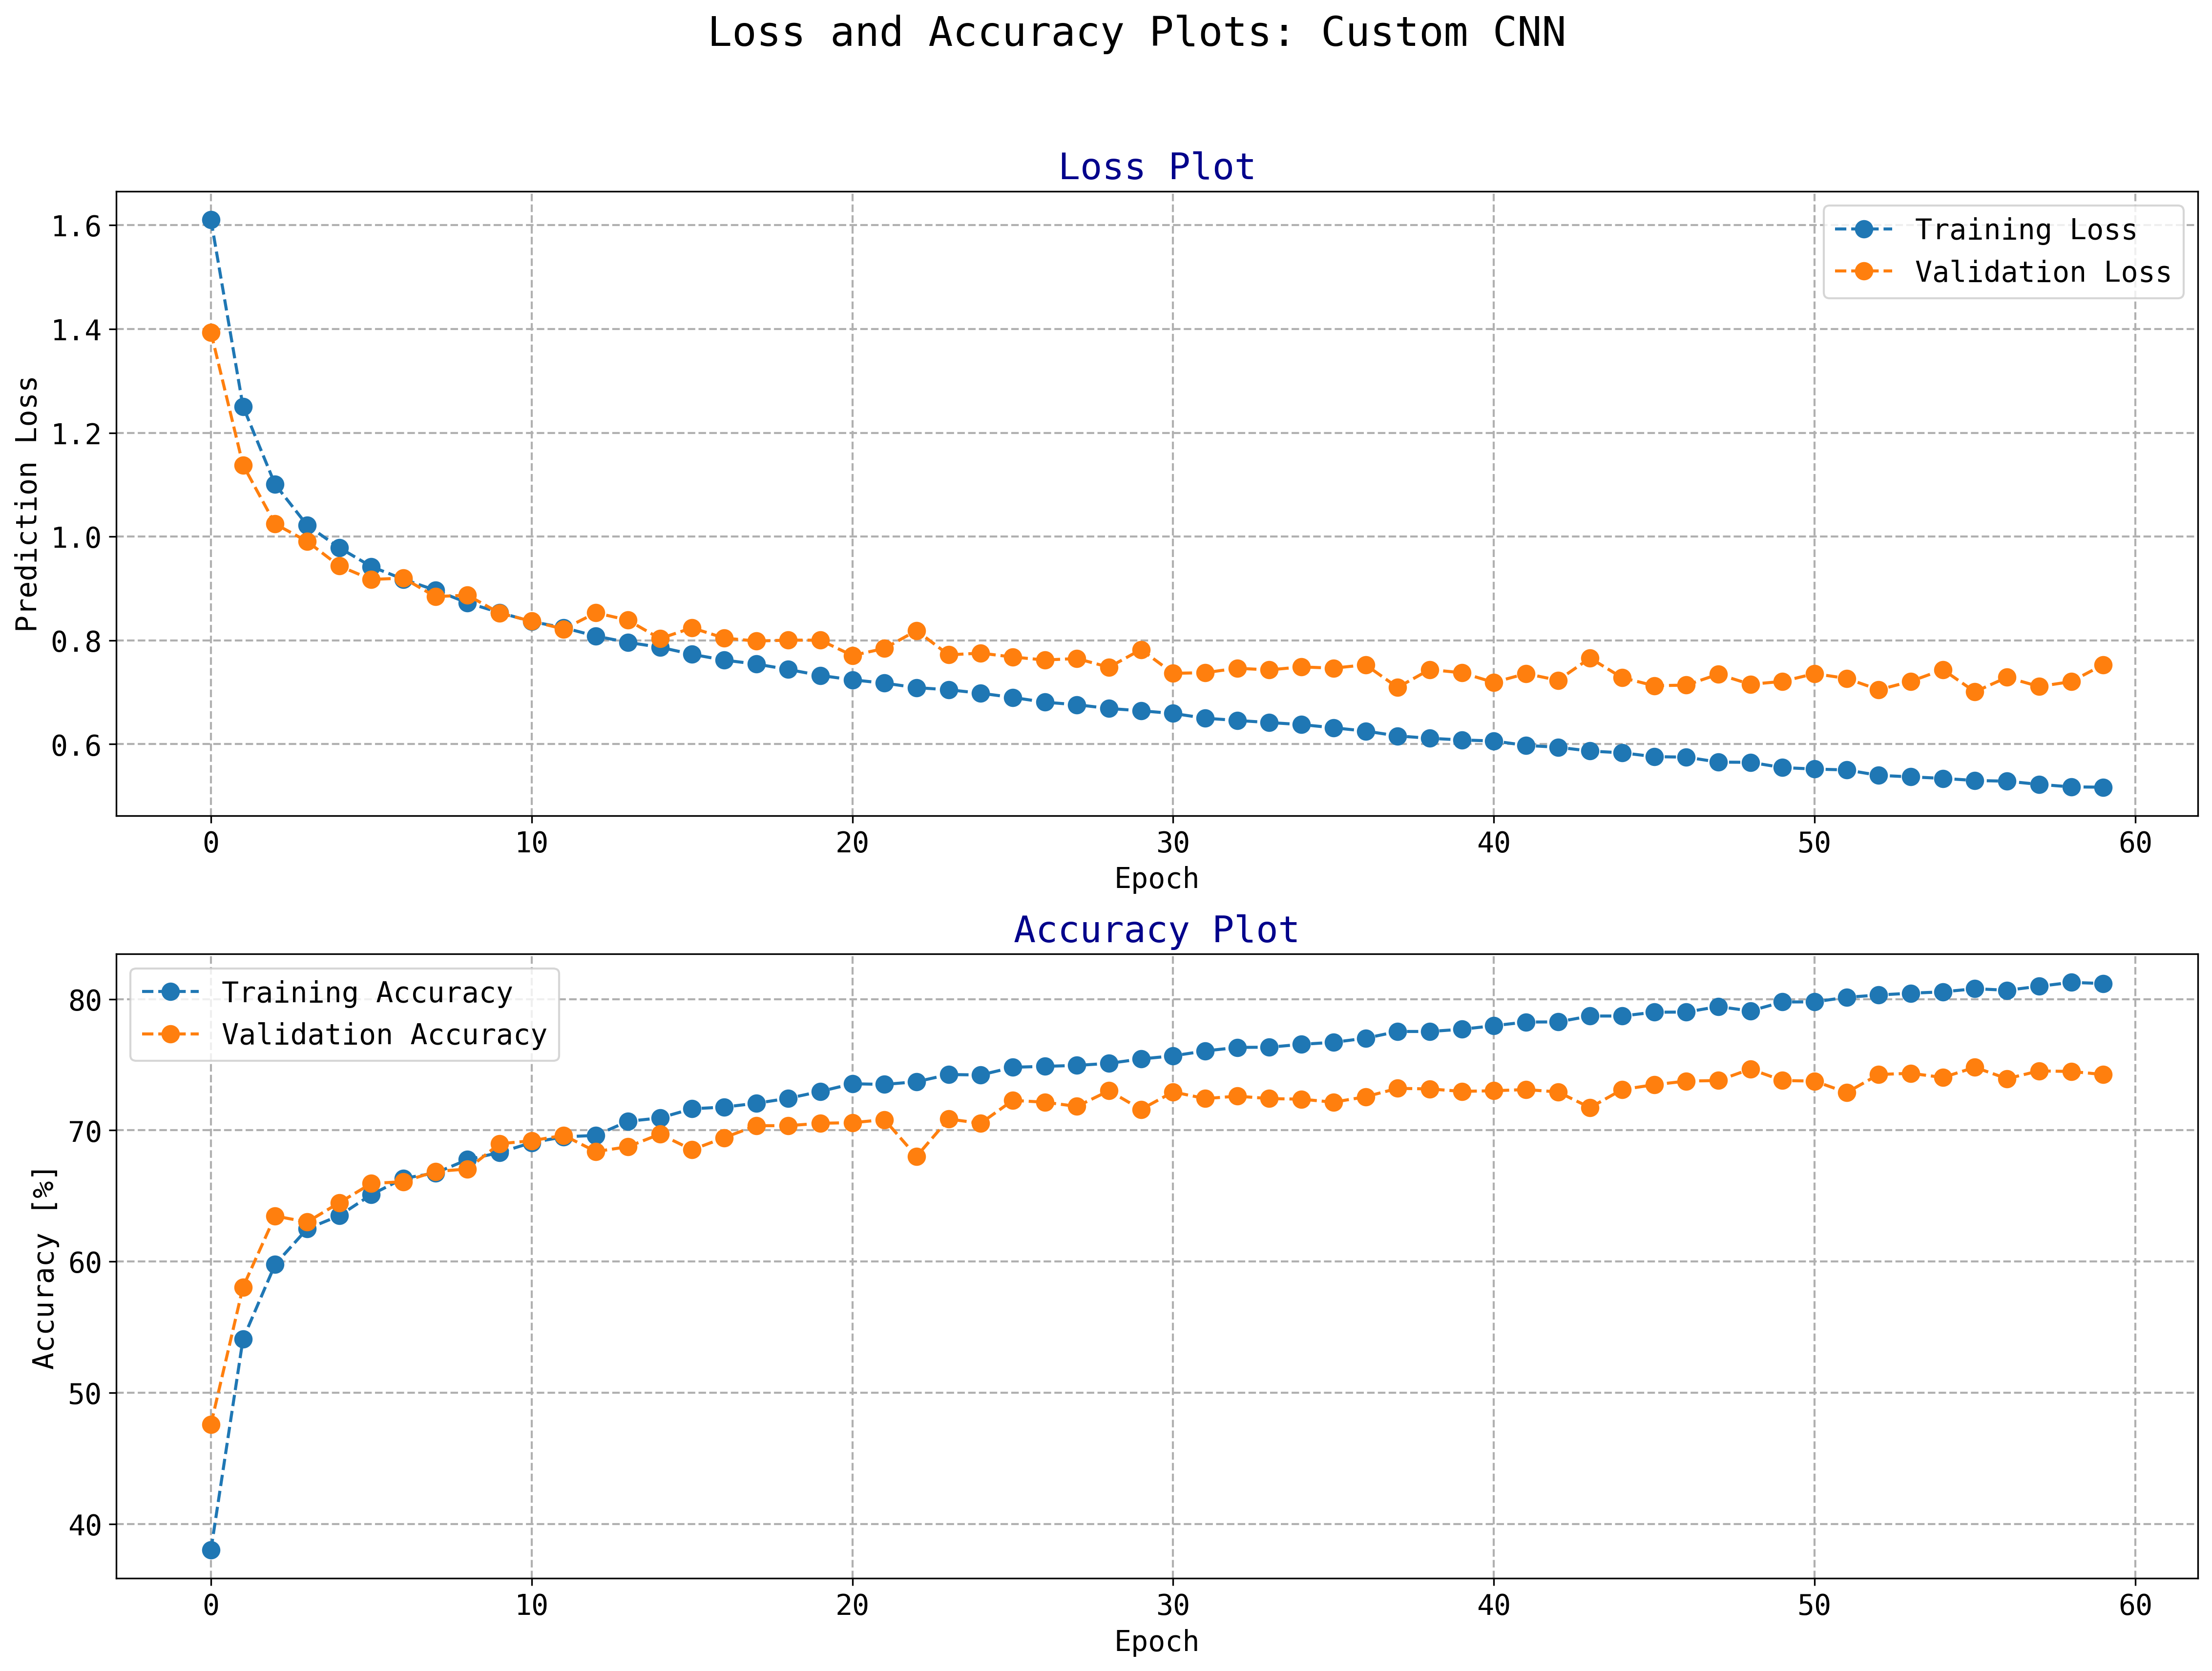

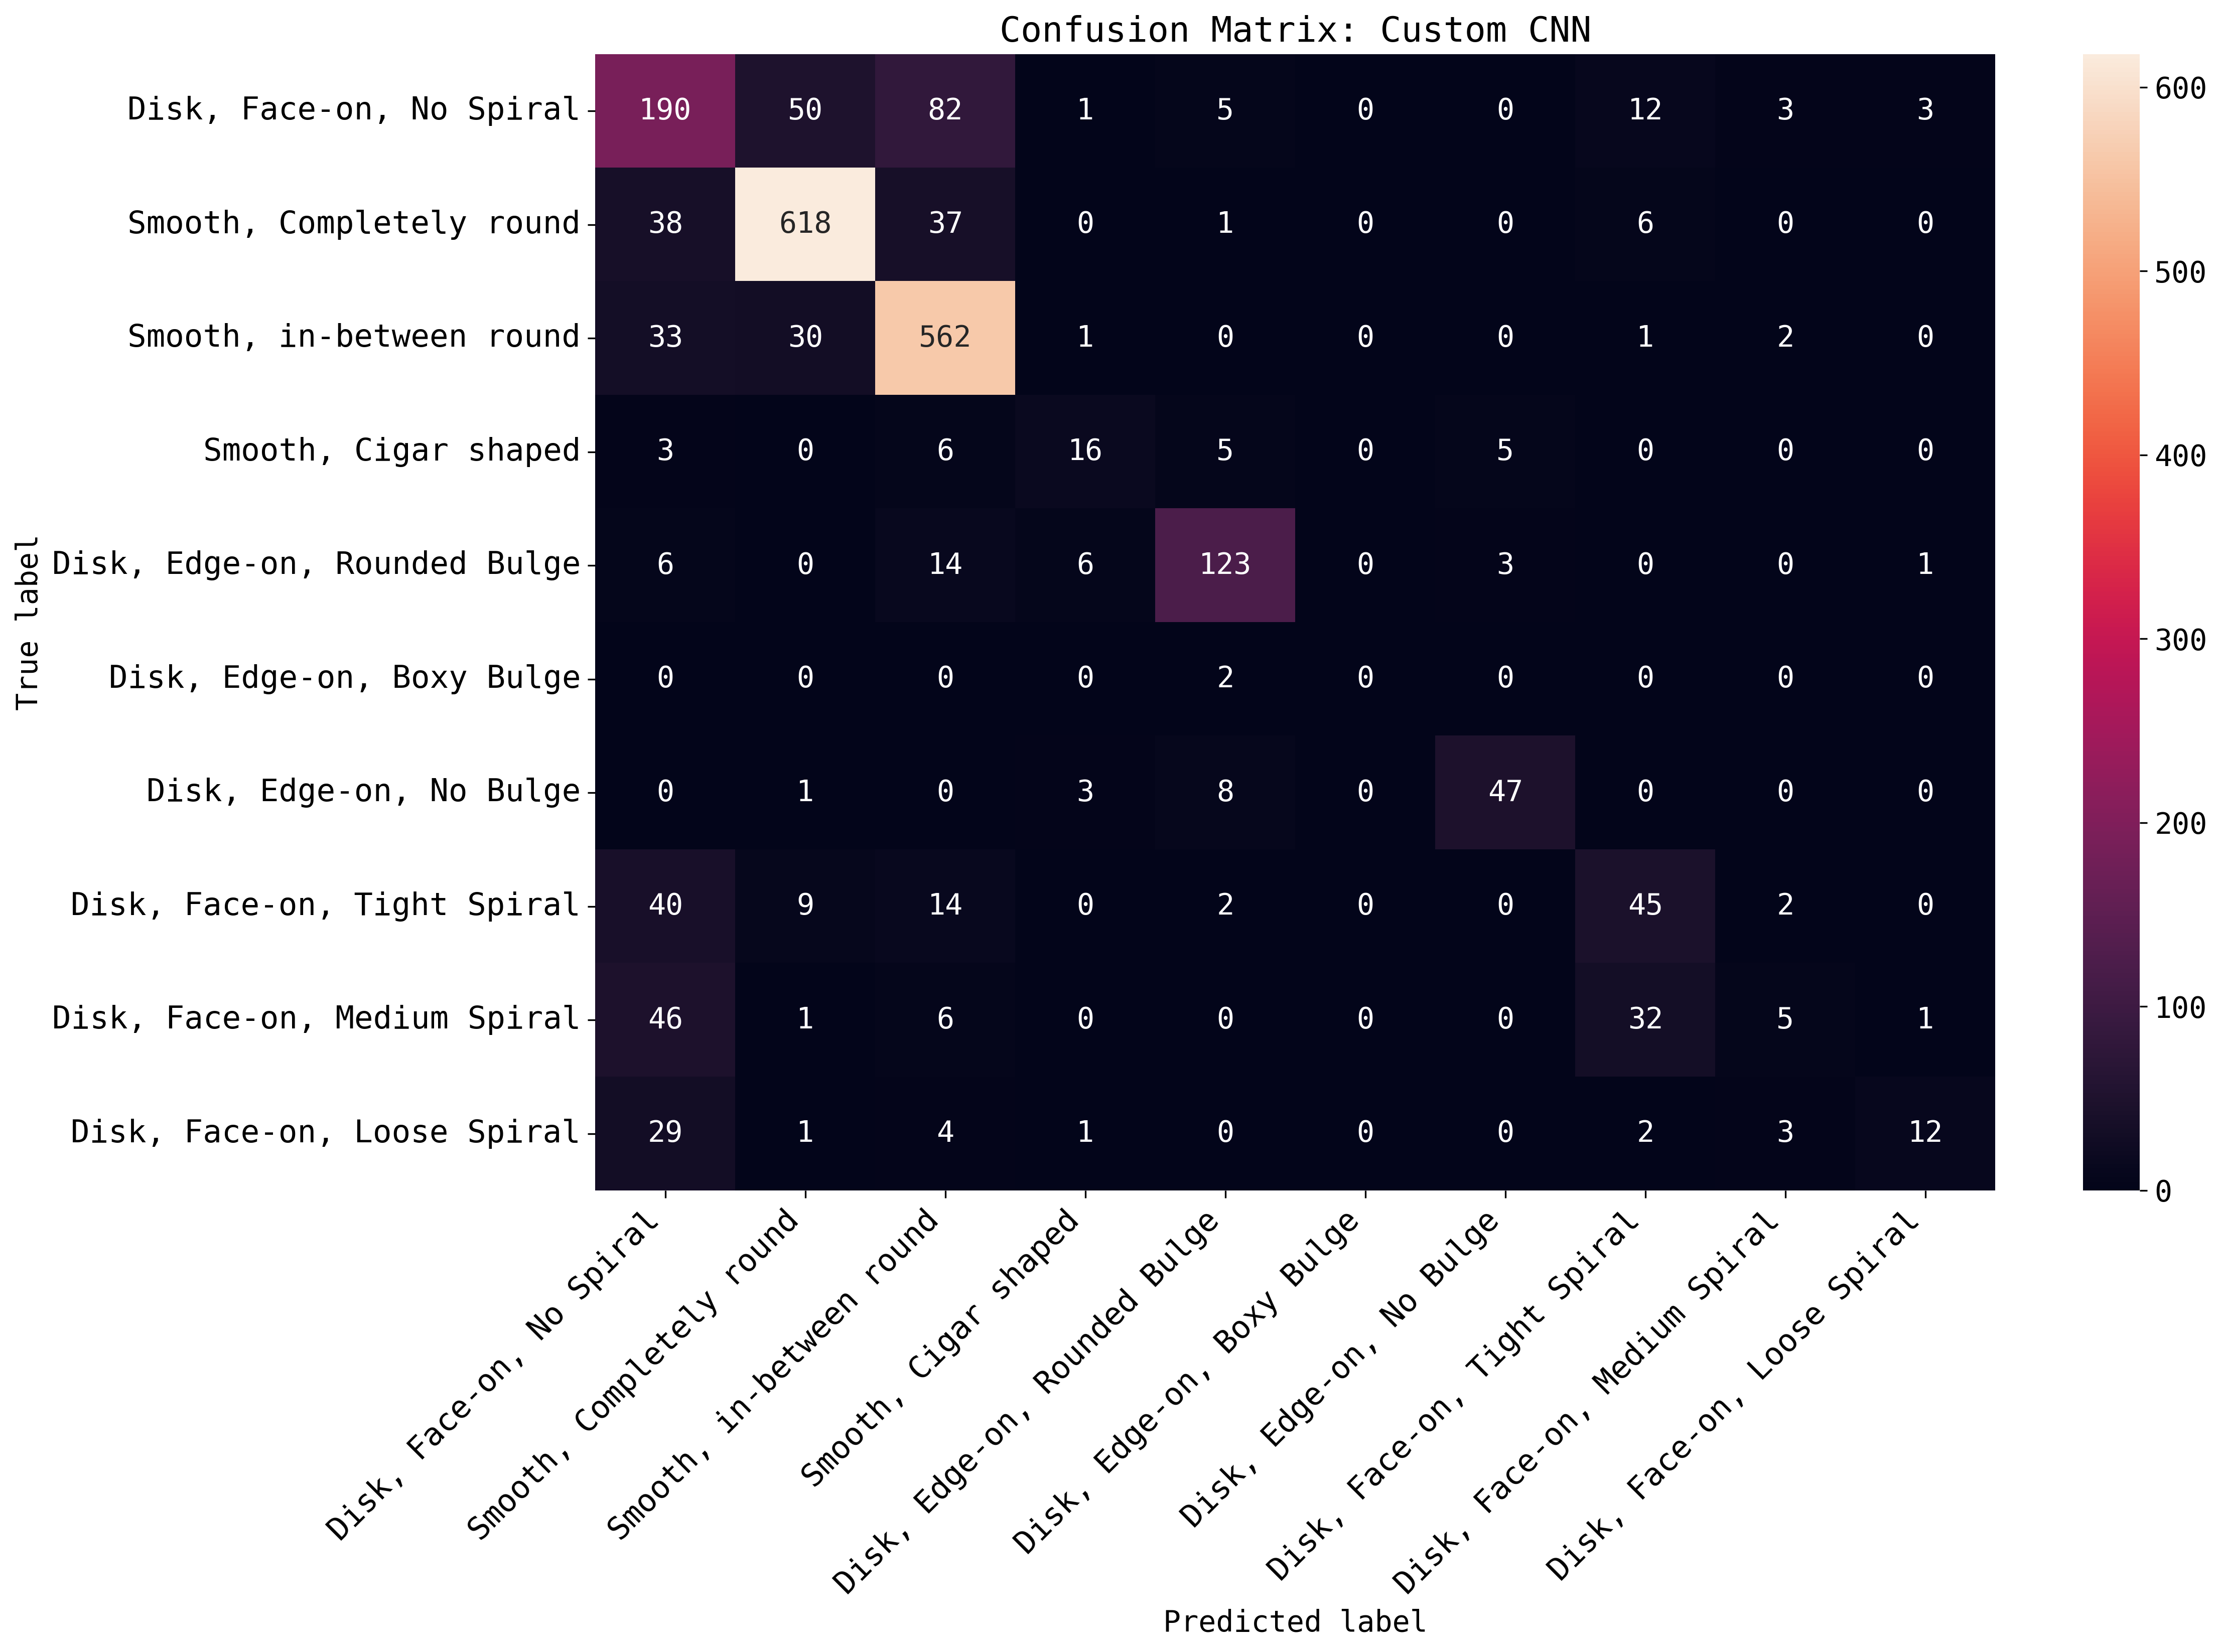

In [45]:
# TODO: Plot the losses and accuracies.
fig,ax = plt.subplots(2,1,figsize=(16,11),dpi=300)
plt.suptitle('Loss and Accuracy Plots: Custom CNN', fontsize=20, y=1.05)
fig.tight_layout(pad=3)

x = range(30)

# loss plot
ax[0].plot(tot_train_loss,'--o',markersize=8,label='Training Loss')
ax[0].plot(tot_val_loss,'--o',markersize=8,label='Validation Loss')
ax[0].grid(linestyle='--', linewidth=1)
ax[0].set_title(f'Loss Plot',fontdict={'fontsize': 18,'color': 'darkblue'})
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Prediction Loss')
ax[0].legend()

# accuracy plot
ax[1].plot(tot_train_accuracy,'--o',markersize=8,label='Training Accuracy')
ax[1].plot(tot_val_accuracy,'--o',markersize=8,label='Validation Accuracy')
ax[1].grid(linestyle='--', linewidth=1)
ax[1].set_title(f'Accuracy Plot',fontdict={'fontsize': 18,'color': 'darkblue'})
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy [%]')
ax[1].legend();

confusion_matrix = torch.zeros(n_classes, n_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = cnn_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


plt.figure(figsize=(15,10),dpi=300)
plt.title('Confusion Matrix: Custom CNN')

import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(confusion_matrix, index=label_names, columns=label_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label');

(c)

In [32]:
# TODO: redo (c) with a ResNet
# Hint: Training is probably quicker on google colab (https://colab.research.google.com/)

resnet = torchvision.models.resnet34()
resnet.fc = nn.Linear(512, n_classes, bias=False)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,pin_memory=True,num_workers=2)

# TODO: instantiate the model, optimizer and criterion
resnet = resnet.to(device)

optimizer = Adam(resnet.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# TODO: implement the training loop, validating after every epoch, and make the requested plots
tot_train_loss,tot_val_loss =[],[]
tot_train_accuracy,tot_val_accuracy = [],[]

min_val_loss = np.Inf

for epoch in tqdm(range(40),total=len(range(40))):
    ind_train_loss,ind_val_loss = 0.0,0.0
    train_accuracy,val_accuracy = 0.0,0.0
    train_total,val_total  = 0.0,0.0

    for (x, y) in train_loader:
        #TODO: train step
        inputs, labels = x,y      

        inputs = inputs.to(device)  
        labels = labels.to(device)
         
        optimizer.zero_grad()   

        outputs = resnet(inputs) 

        loss = criterion(outputs, labels)
        loss.backward()             
        optimizer.step()           

        ind_train_loss += loss.item()  
    
        train_total += labels.size(0)    
        _, predicted = torch.max(outputs, 1)       
        train_accuracy += (predicted == labels).sum().item()  

    tot_train_loss.append(ind_train_loss/len(train_loader))  
    tot_train_accuracy.append((100 * train_accuracy / train_total))  

    # TODO: validate 
    with torch.no_grad(): 
            resnet.eval() 
            for data in val_loader: 
               inputs, labels = data
               inputs = inputs.to(device)
               labels = labels.to(device)

               outputs = resnet(inputs)
               val_loss = criterion(outputs, labels)
             
               ind_val_loss += val_loss.item() 

               val_total += labels.size(0) 
               _, predicted = torch.max(outputs, 1) 
               val_accuracy += (predicted == labels).sum().item() 
    
    val_loss_value = ind_val_loss/len(val_loader) 
    tot_val_loss.append(val_loss_value)   

    tot_val_accuracy.append((100 * val_accuracy / val_total)) 

    if val_loss_value < min_val_loss  :
        print(f'Epoch: {epoch}; Validation loss decreased: ({min_val_loss:.6f} --> {val_loss_value:.6f}). Model Accuracy: Training-{(100 * train_accuracy / train_total):.2f}%; Validation-{(100 * val_accuracy / val_total):.2f}%; . Saving model ...')
        torch.save({
                'epoch': epoch,
                'model_state_dict': resnet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model_resnet.pth')
        min_val_loss = val_loss_value 

print('Finished Training')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0; Validation loss decreased: (inf --> 0.644465). Model Accuracy: Training-83.50%; Validation-76.18%; . Saving model ...
Epoch: 1; Validation loss decreased: (0.644465 --> 0.633274). Model Accuracy: Training-85.11%; Validation-76.78%; . Saving model ...
Epoch: 2; Validation loss decreased: (0.633274 --> 0.618577). Model Accuracy: Training-87.28%; Validation-79.58%; . Saving model ...
Finished Training


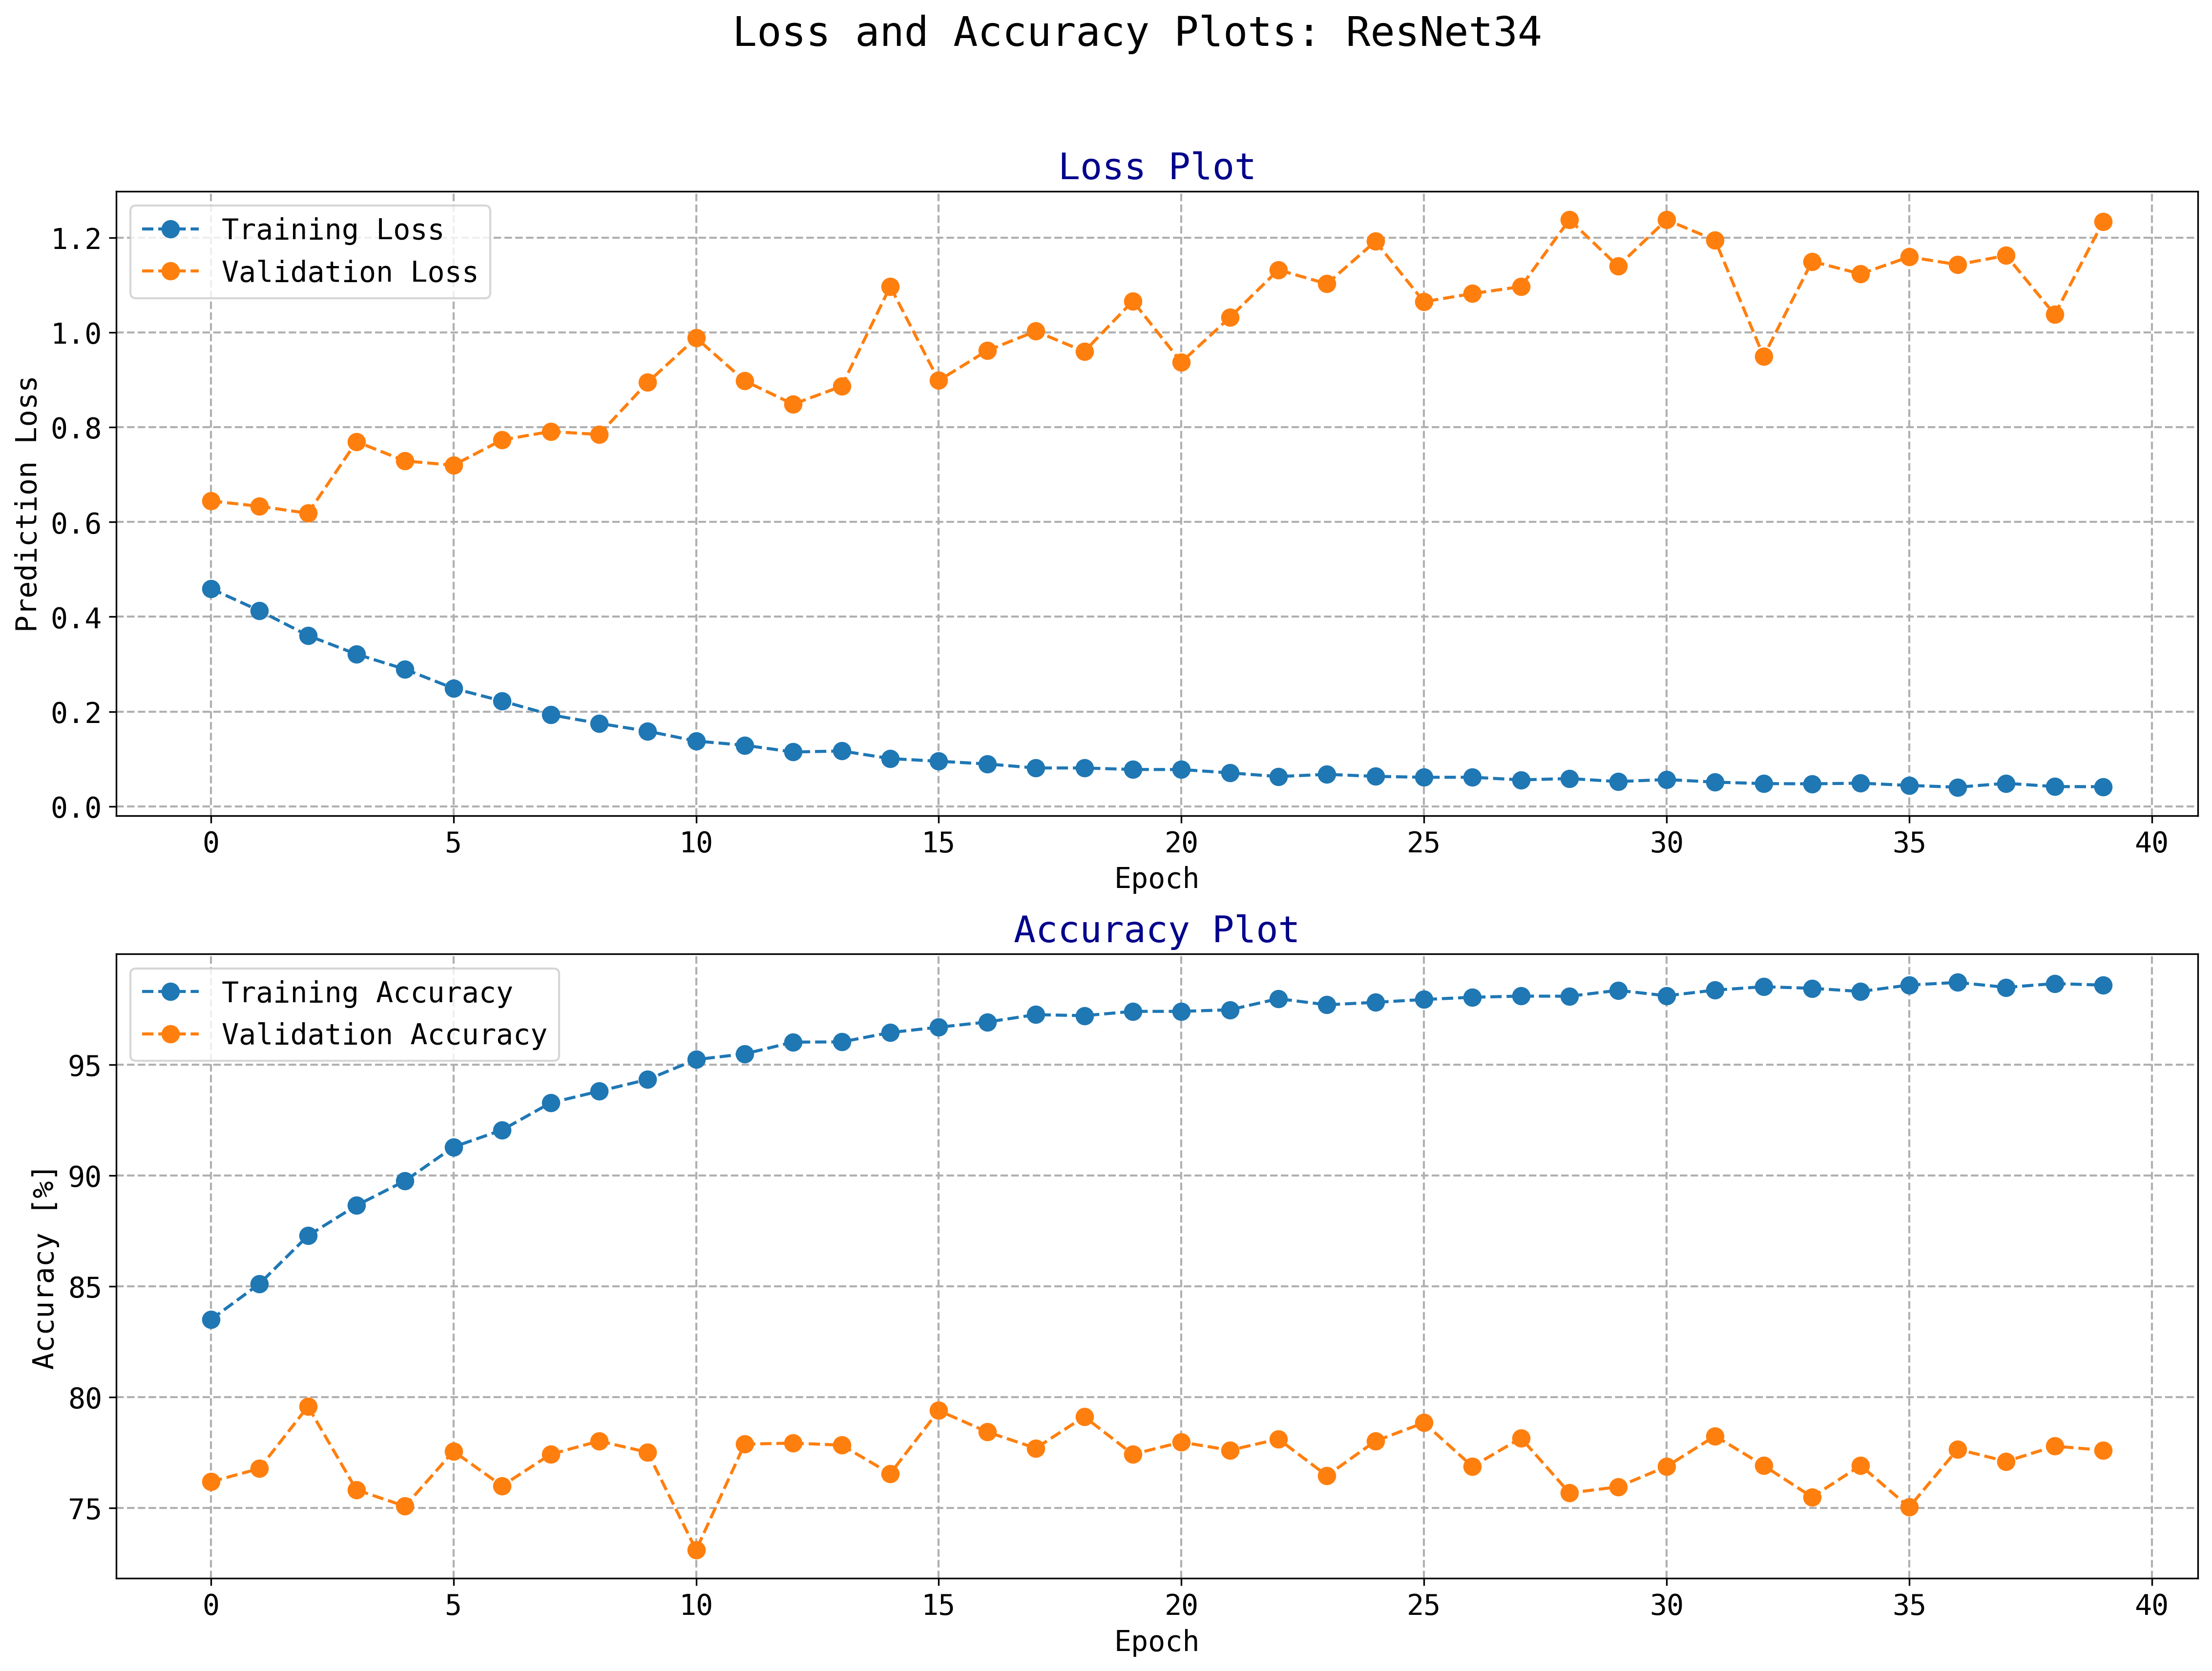

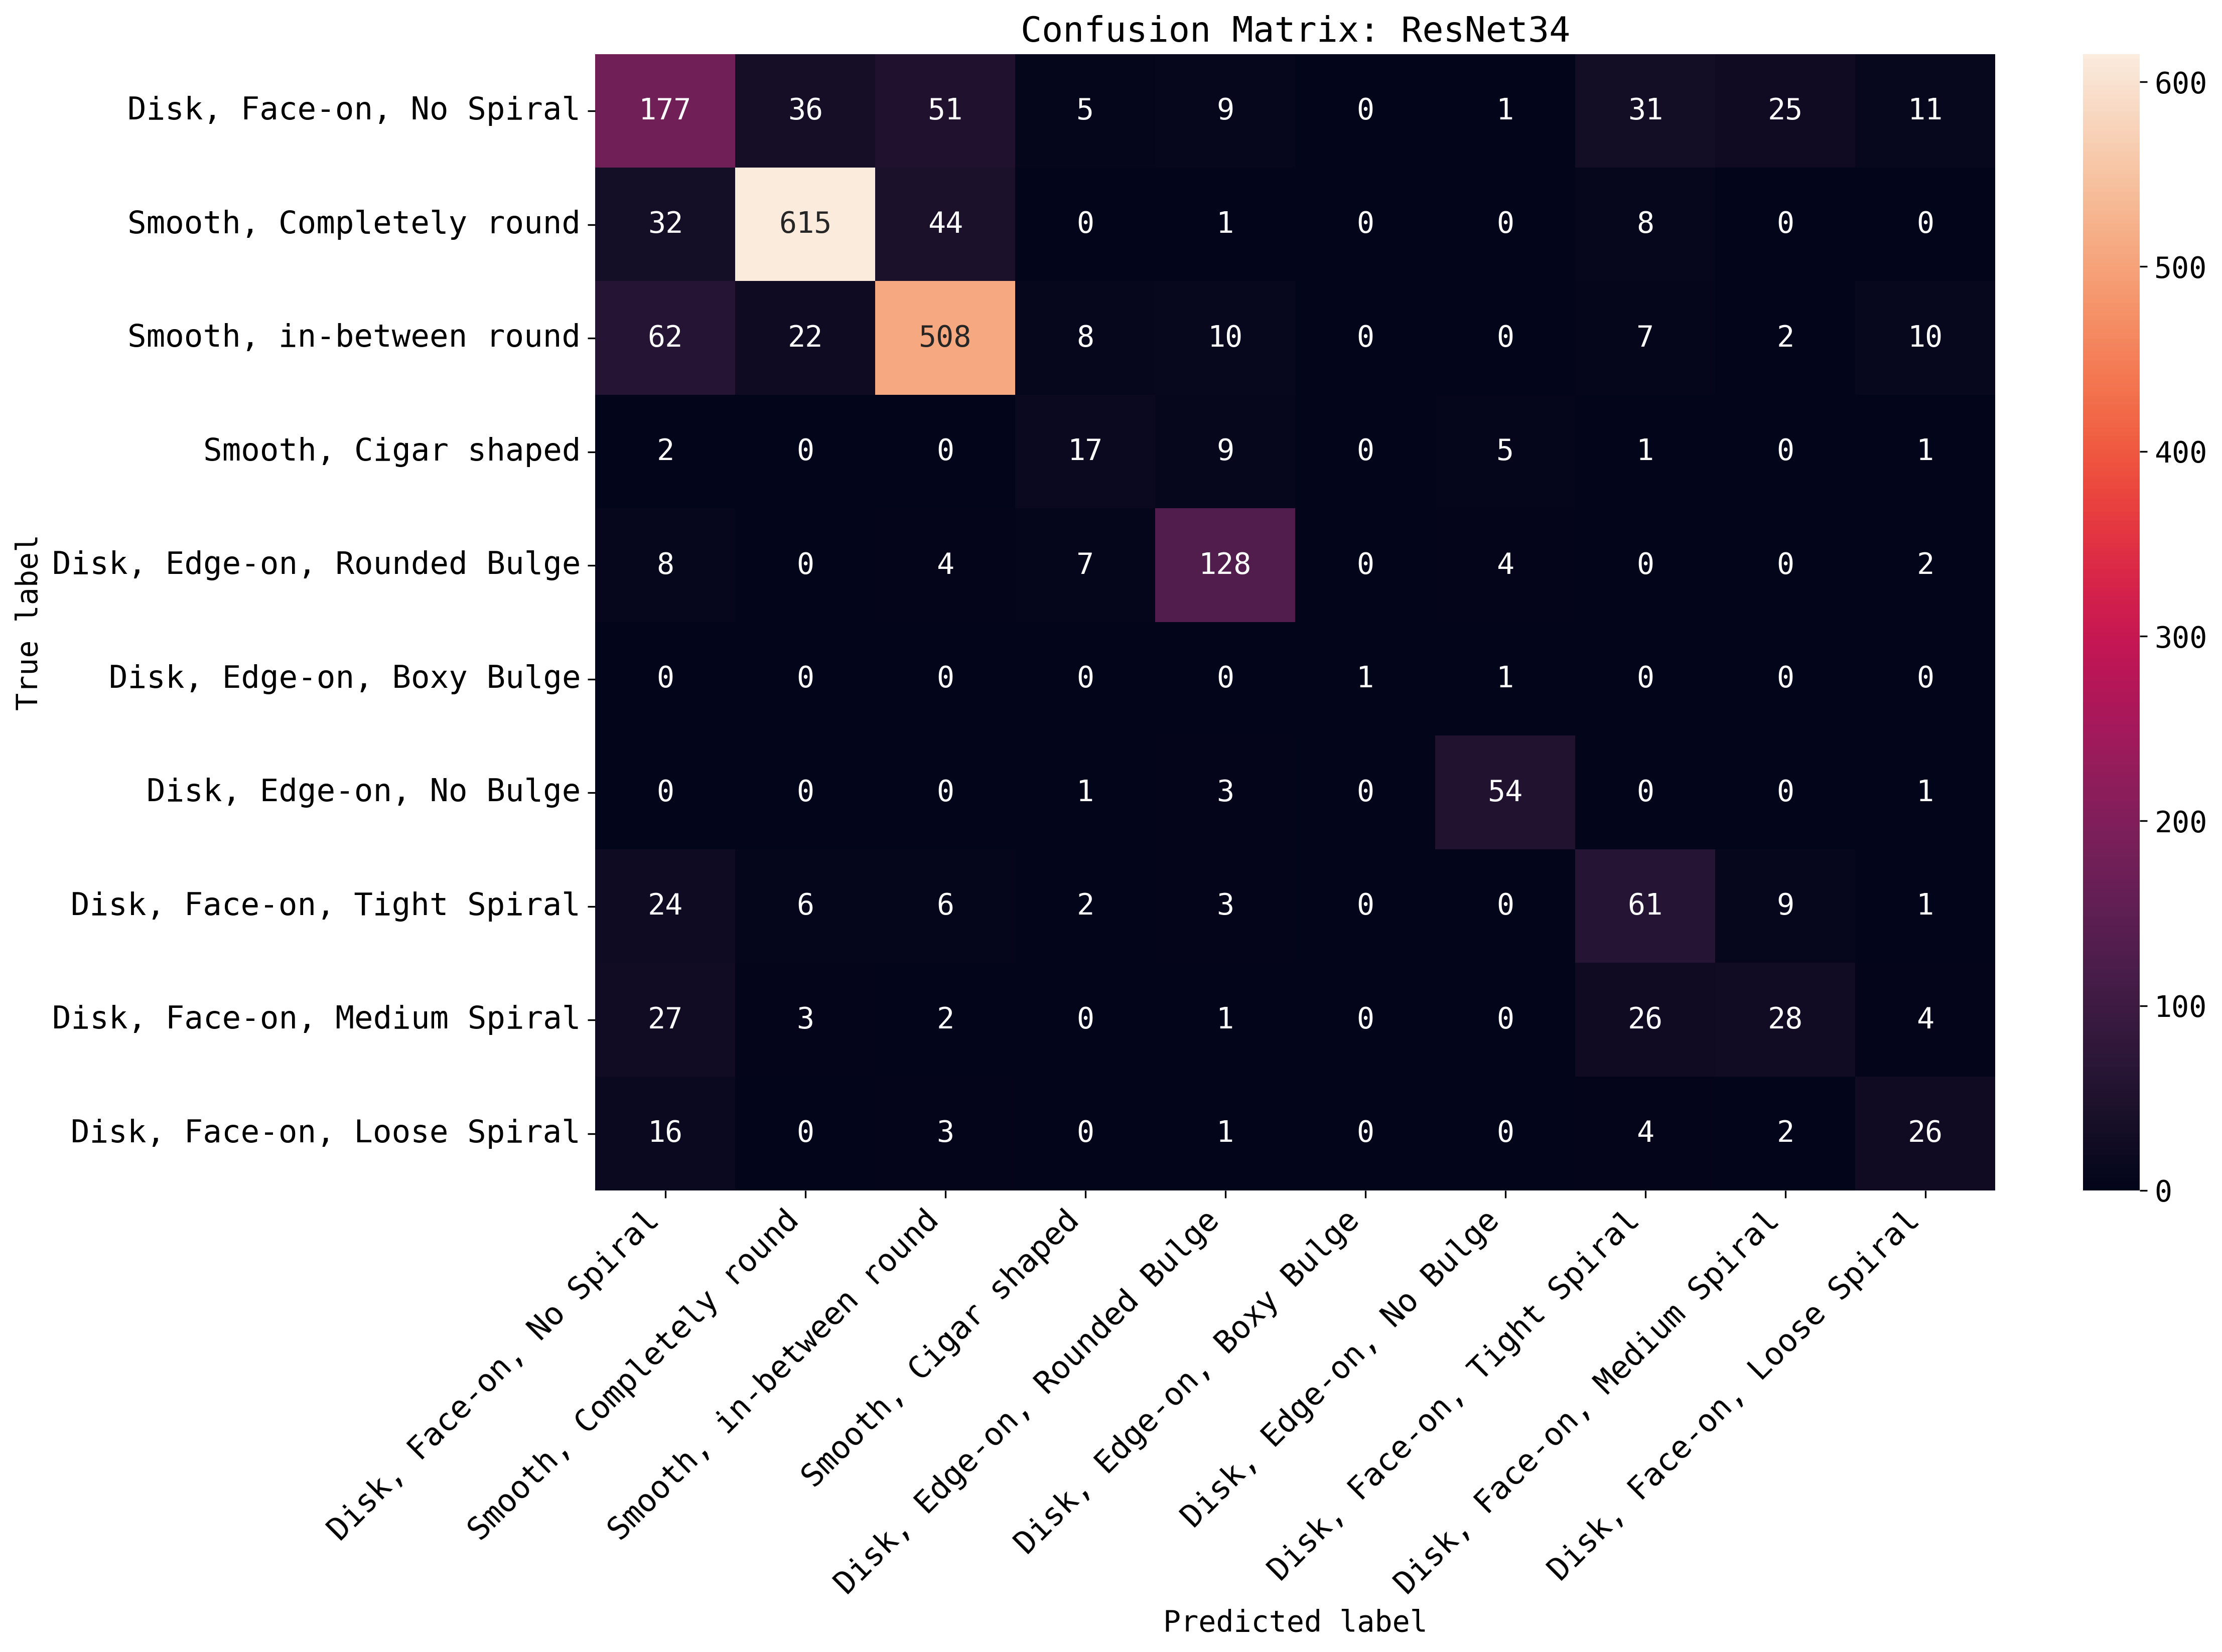

In [42]:
# TODO: Plot the losses and accuracies.
fig,ax = plt.subplots(2,1,figsize=(16,11),dpi=300)
plt.suptitle('Loss and Accuracy Plots: ResNet34', fontsize=20, y=1.05)
fig.tight_layout(pad=3)

x = range(30)

# loss plot
ax[0].plot(tot_train_loss,'--o',markersize=8,label='Training Loss')
ax[0].plot(tot_val_loss,'--o',markersize=8,label='Validation Loss')
ax[0].grid(linestyle='--', linewidth=1)
ax[0].set_title(f'Loss Plot',fontdict={'fontsize': 18,'color': 'darkblue'})
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Prediction Loss')
ax[0].legend()

# accuracy plot
ax[1].plot(tot_train_accuracy,'--o',markersize=8,label='Training Accuracy')
ax[1].plot(tot_val_accuracy,'--o',markersize=8,label='Validation Accuracy')
ax[1].grid(linestyle='--', linewidth=1)
ax[1].set_title(f'Accuracy Plot',fontdict={'fontsize': 18,'color': 'darkblue'})
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy [%]')
ax[1].legend();

confusion_matrix = torch.zeros(n_classes, n_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = cnn_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


plt.figure(figsize=(15,10),dpi=300)
plt.title('Confusion Matrix: ResNet34')
df_cm = pd.DataFrame(confusion_matrix, index=label_names, columns=label_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label');

(d)

According to the resources available online, we got to know:
 - CNN, in general, is not rotational invariant. But it is the Max Pooling layer which brings the Rotional Invariance to the CNN. Though, it's a crude method.
 - The intuitive way to have our CNN model learn the rotations is to include manually rotated images in the training set and have our model learn that. 
 - The other way which I learned is to use the concept of Equivariance. For ex. using Capsule Nets, which uses nested set of neural Layers. Ref: https://hackernoon.com/what-is-a-capsnet-or-capsule-network-2bfbe48769cc 